In [7]:
from math import floor
import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
import numpy as np
import common # type: ignore
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector
from IPython.display import display, Markdown, Latex, HTML
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import quantiphy as qq
import warnings
import enum

EPS_TH = 0.5
DATASET = "CTU-13"
database = common.Database()
dataset = common.Dataset()

slots = {}
# slots[1] = common.Slot(database, 1 * 60 * 60, EPS_TH, DATASET)
slots[12] = common.Slot(database, 12 * 60 * 60, EPS_TH, DATASET)
# slots[24] = common.Slot(database, 24 * 60 * 60, EPS_TH, DATASET)
# slots[4 * 24] = common.Slot(database, 4 * 24 * 60 * 60, EPS_TH, DATASET)
# slots[7 * 24] = common.Slot(database, 7 * 24 * 60 * 60, EPS_TH, DATASET)



In [5]:
import os
import importlib
import latex
importlib.reload(latex)

from latex import dm, pp, ptime, Cites, AC
from latex import Tables, Table, Figure, Figures
from latex import is_latex, set_latex, unset_latex

# First 5 days

## Windows over time

The number of windows active for a slot of time, which is 3600 seconds.

The last window timestamp is: 1493733000.0 (17288 days).

The last window timestamp _normalized_ is: 431998.951 (4 days).

Then, whit the slot value equal to 0. days, the maximum number of slot is 119.

This huge number is misplacing, since the:
- 163090 windows (the 99%) are within the first 117.0 slots.
- 1155 windows (the 1%) are within the last 2.0 slots.

> We decide to ignore the last 103893 windows, corresponding to the last 89.0 slots.

#### Pitfall **Spurius Correlations** for *window\_time\_start*:

> It's obvious that time start/end should not be used.

This plot demonstrate that using the _window\_time\_start/end_ feature would establish a correlation with the DGA class, since just DGA windows starts after the first slot.

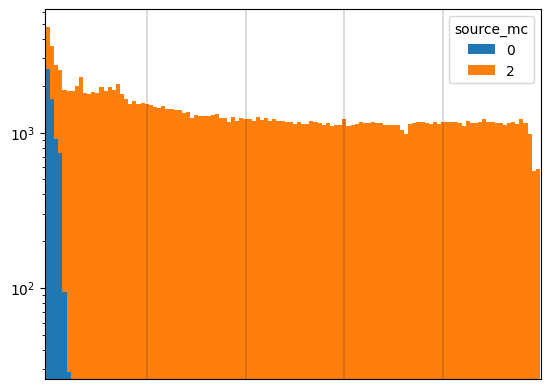

# The window distribution over sources

We can see that there are 

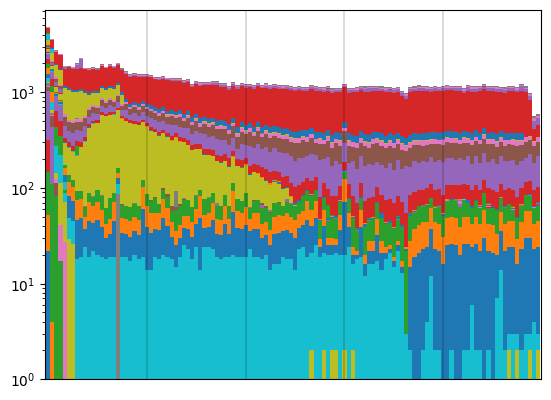

# Positives with threshold 0.5

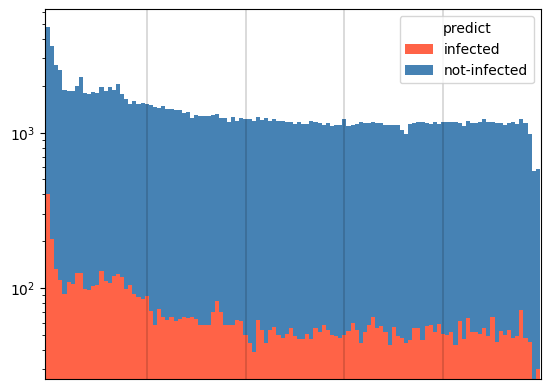

In [3]:
SEC_PER_SLOT = 1 * 60 * 60
DAY_SEC = 24 * 60 * 60
N_DAYS = 5
SLOT_PER_DAY = DAY_SEC / SEC_PER_SLOT

df = dataset.df.copy().sort_values("time_s_end_norm")
df = df[df["time_s_end_norm"] < N_DAYS * DAY_SEC]
n_slot_max = math.floor(df["time_s_end_norm"].max() / SEC_PER_SLOT)
df["slot_end"] =  np.floor(df["time_s_end_norm"] / SEC_PER_SLOT)

display(Markdown("# First %s days" % N_DAYS))

display(Markdown("## Windows over time"))
display(Markdown("The number of windows active for a slot of time, which is %s seconds." % SEC_PER_SLOT))


display(Markdown("The last window timestamp is: %s (%s days)." %(df["time_s_end"].max(), math.floor(df["time_s_end"].max() / DAY_SEC))))
display(Markdown("The last window timestamp _normalized_ is: %s (%s days)." % (df["time_s_end_norm"].max(), math.floor(df["time_s_end_norm"].max() / DAY_SEC))))



desc = df["slot_end"].describe(percentiles=[0.95, 0.99, 0.999])

display(Markdown("Then, whit the slot value equal to %.2s days, the maximum number of slot is %s." % (SEC_PER_SLOT / DAY_SEC, n_slot_max)))
display(Markdown("""This huge number is misplacing, since the:
- %s windows (the 99%%) are within the first %s slots.
- %s windows (the 1%%) are within the last %s slots.""" % ((df["slot_end"] <= desc.loc['99%']).sum(), desc.loc['99%'], (df["slot_end"] > desc.loc['99%']).sum(), df["slot_end"].max() - desc.loc['99%'])))


n_slot_th = 30

display(Markdown("> We decide to ignore the last %s windows, corresponding to the last %s slots." % ((df["slot_end"] > n_slot_th).sum(), df["slot_end"].max() - n_slot_th)))




display(Markdown("#### Pitfall **Spurius Correlations** for *window\\_time\\_start*:"))

display(Markdown("> It's obvious that time start/end should not be used."))

display(Markdown("This plot demonstrate that using the _window\\_time\\_start/end_ feature would establish a correlation with the DGA class, since just DGA windows starts after the first slot."))

tmp = df[["source_mc", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
ax.set_xticks([])
ax.set_xlabel(None)
plt.show()



display(Markdown("# The window distribution over sources"))
display(Markdown("We can see that there are "))
tmp = df[["source_id", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False)
ax.set_xticks([])
ax.set_xlabel(None)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
    # ax.text(day * DAY_SEC / SLOT_SEC + 0.1, 0,  'blah', rotation=90)
plt.show()



display(Markdown("# Positives with threshold 0.5"))
df["predict"] = "infected"
df["predict"] = df["predict"].where(df["eps_NONE_0.500"] > 0.5, "not-infected")
tmp = df[["predict", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=True, color=[ "tomato", "steelblue"])
ax.set_xticks([])
ax.set_xlabel(None)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
plt.show()


### Using threshold 0.5

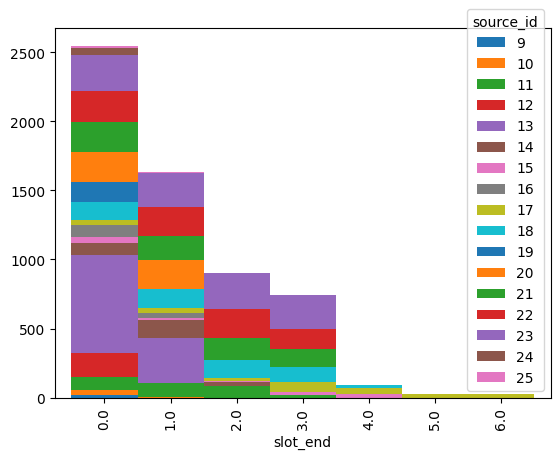

### Using threshold 0.5

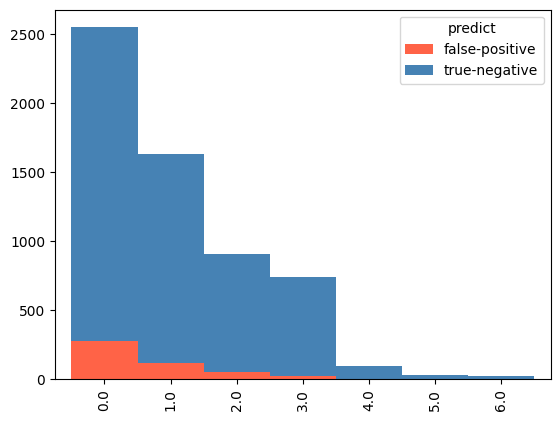

In [22]:
SEC_PER_SLOT = 1 * 60 * 60
DAY_SEC = 24 * 60 * 60
N_DAYS = 1
SLOT_PER_DAY = DAY_SEC / SEC_PER_SLOT

df = dataset.df.copy().sort_values("time_s_end_norm")
df = df[df["source_mc"] == 0]
df["slot_end"] =  np.floor(df["time_s_end_norm"] / SEC_PER_SLOT)

display(Markdown("### Using threshold 0.5"))



tmp = df[["source_id", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=False, legend=True)
plt.show()

display(Markdown("### Using threshold 0.5"))

df["predict"] = "false-positive"
df["predict"] = df["predict"].where(df["eps_NONE_0.500"] > 0.5, "true-negative")

tmp = df[["predict", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=False, legend=True, color=[ "tomato", "steelblue"])
# ax.set_xticks([])

ax.set_xlabel(None)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
plt.show()